In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import KID_S21 as S21
import pandas as pd
import glob
from scipy.stats import norm


import io
import base64
from IPython.display import display, HTML


%matplotlib widget

In [2]:
master_array = np.loadtxt('LT361w2chip4_master.txt', skiprows=1, delimiter=',')
Qs = np.loadtxt('LT361w2chip4nibbled_Qs.txt', skiprows=1, delimiter='\t')
f0_meas = master_array[:, 9]
f0_mapped = f0_meas
f0_Q = Qs[:, 0]
Ql = Qs[:, 1]
Qc = Qs[:, 3]
Qi = Qs[:, 2]
phi = Qs[:, 4]

min_df = 0.001
df0s = f0_Q[1:] - f0_Q[:-1]
df_mask = np.zeros(f0_Q.shape, dtype=bool)
too_close = df0s < min_df
too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))

Qi_mask = (Qi > 1e5)  & (Qi < 2e6)
Qc_mask = Qc < 1.5e5
mask = Qi_mask & Qc_mask & ~too_close_mask

Qs[~mask] = np.nan
f0_Q = Qs[:, 0]
Ql = Qs[:, 1]
Qc = Qs[:, 3]
Qi = Qs[:, 2]
phi = Qs[:, 4]

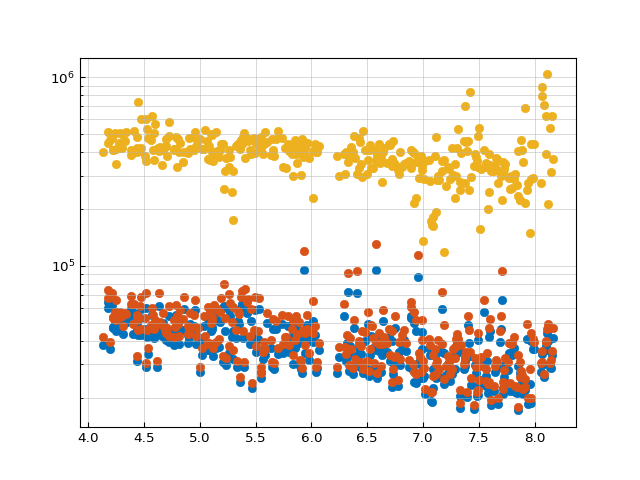

In [3]:
fig, ax = plt.subplots()
ax.scatter(f0_Q, Ql)
ax.scatter(f0_Q, Qc)
ax.scatter(f0_Q, Qi)
ax.set_yscale('log')

In [4]:
master_array = np.loadtxt('LT361w2chip4_master.txt', skiprows=1, delimiter=',')
Qs = np.loadtxt('LT361w2chip4nibbled_Qs.txt', skiprows=1, delimiter='\t')
f0_meas = master_array[:, 9]
f0_mapped = f0_meas
f0_Q = Qs[:, 0]
Ql = Qs[:, 1]
Qc = Qs[:, 3]
Qi = Qs[:, 2]
phi = Qs[:, 4]

min_df = 0.001
df0s = f0_Q[1:] - f0_Q[:-1]
df_mask = np.zeros(f0_Q.shape, dtype=bool)
too_close = df0s < min_df
too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))

Qi_mask = (Qi > 1e5)  & (Qi < 2e6)
Qc_mask = Qc < 1.5e5
mask = Qi_mask & Qc_mask & ~too_close_mask

Qs[~mask] = np.nan
extra_data = {
    'KID': np.full(f0_meas.shape, '', dtype=object),
    'f0_Q': np.full(f0_meas.shape, np.nan),
    'Ql': np.full(f0_meas.shape, np.nan),
    'Qc': np.full(f0_meas.shape, np.nan),
    'Qi': np.full(f0_meas.shape, np.nan),
    'dw': np.full(f0_meas.shape, np.nan),
}
gebruikt = np.full(f0_meas.shape, False)

# -- 4. Match alleen geldige f0_meas én als f0_Q > f0_meas --
tolerance = 0.001  # GHz

for i, row in enumerate(Qs):
    if ~np.isnan(row[0]):
        f_q = row[0]
        verschil = np.abs(f0_meas - f_q)

    # Vind kandidaten: nog niet gebruikt, niet te dicht, binnen tolerantie, én f0 < f_q
    kandidaten = np.where(
        (~gebruikt)
    )[0]

    if len(kandidaten) == 0:
        continue

    # Kies dichtstbijzijnde geldige kandidaat
    idx = kandidaten[np.nanargmin(verschil[kandidaten])]

    # Vul extra_data
    extra_data['KID'][idx] = i
    extra_data['f0_Q'][idx] = f_q
    extra_data['Ql'][idx] = row[1]
    extra_data['Qc'][idx] = row[3]
    extra_data['Qi'][idx] = row[2] 
    # extra_data['dw'][idx] = row['dw']

    gebruikt[idx] = True

# -- 5. Combineer alles --
extended_master_array = np.column_stack((
    master_array,
    extra_data['KID'],
    extra_data['f0_Q'],
    extra_data['Ql'],
    extra_data['Qc'],
    extra_data['Qi'],
    extra_data['dw']
))

colnames = ['col0', 'col1', 'col2', 'col3', 'col4', 'col5', 'f0_meas','col7','col8','col9', 'KID', 'f0_Q', 'Ql', 'Qc', 'Qi','dw']
#colnames = ['col0', 'col1', 'col2', 'col3', 'col4', 'col5', 'f0_meas', 'KID', 'f0_Q', 'Ql', 'Qc', 'Qi', 'dw']
df_extended = pd.DataFrame(extended_master_array, columns=colnames)

# Preview
#print(df_extended.head())
display(df_extended[['KID', 'col7', 'f0_Q', 'Ql', 'Qc', 'Qi','dw']])




,KID,col7,f0_Q,Ql,Qc,Qi,dw
0,0,4.15617,4.127923,37917.418305,41861.022146,402490.197203,NaN
1,1,4.202063,4.173801,64132.939837,74842.95207,448169.286672,NaN
2,2,4.207842,4.179545,59684.866524,67510.562687,514888.239831,NaN
3,3,4.219745,4.191041,36336.772087,39435.500206,462434.498324,NaN
4,,4.993571,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
395,389,8.191332,8.13412,28900.077674,30540.220117,538132.975861,NaN
396,390,8.198675,8.145143,28605.074446,31461.806295,315033.877458,NaN
397,391,8.216365,8.159168,33487.79311,35379.42566,626326.125825,NaN
398,392,8.223389,8.169495,41454.417214,46701.600048,368957.529087,NaN


Number of NaNs in f0_Q: 7


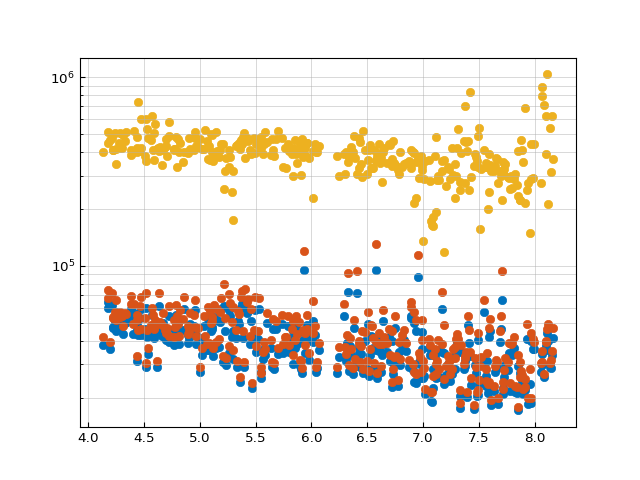

In [5]:
fig, ax = plt.subplots()
ax.scatter(df_extended['f0_Q'], df_extended['Ql'], label='f0_meas vs f0_Q')
ax.scatter(df_extended['f0_Q'], df_extended['Qc'], label='f0_meas vs f0_Q')
ax.scatter(df_extended['f0_Q'], df_extended['Qi'], label='f0_meas vs f0_Q')
ax.set_yscale('log')
num_nans_f0_Q = df_extended['f0_Q'].isna().sum()
print(f"Number of NaNs in f0_Q: {num_nans_f0_Q}")

In [6]:
nr = len(f0_mapped)
f0_dark = Qs[:, 0]
tones = np.empty(nr)
tones[:] = np.nan
Qs_sorted = np.empty((nr, 5))
Qs_sorted[:] = np.nan
idxs = np.empty(nr)
idxs[:] = np.nan
for id, f0 in enumerate(f0_mapped):
    if ~np.isnan(f0):
        closest =  np.nanargmin(np.abs(f0 - f0_dark))
        if ~np.isnan(f0_dark[closest]):
            tone = f0_dark[closest]
            Q = Qs[closest]
            if closest in idxs:
                idx_location = np.where(idxs == closest)[0]
                if len(idx_location) == 1:
                    prev_id = idx_location[0]
                    prev_f0 = f0_mapped[prev_id]
                    curr_diff = np.abs(f0 - tone)
                    prev_diff = np.abs(prev_f0 - tone)
                    if curr_diff < prev_diff:
                        tones[prev_id] = np.nan
                        Qs_sorted[prev_id] = np.nan
                        idxs[prev_id] = np.nan
                    else:
                        tone = np.nan
                        Q = np.nan
                        closest = np.nan
                else:
                    print('more than one match')
                    tone = np.nan
                    Q = np.nan
                    closest = np.nan
            else:
                pass
        else:
            tone = np.nan
            Q = np.nan
            closest = np.nan
    else:
        tone = np.nan
        Q = np.nan
        closest = np.nan
    tones[id] = tone
    Qs_sorted[id] = Q
    idxs[id] = closest

f0 = Qs_sorted[:, 0]
Ql = Qs_sorted[:, 1]
Qc = Qs_sorted[:, 3]
Qi = Qs_sorted[:, 2]
phi = Qs_sorted[:, 4]

64

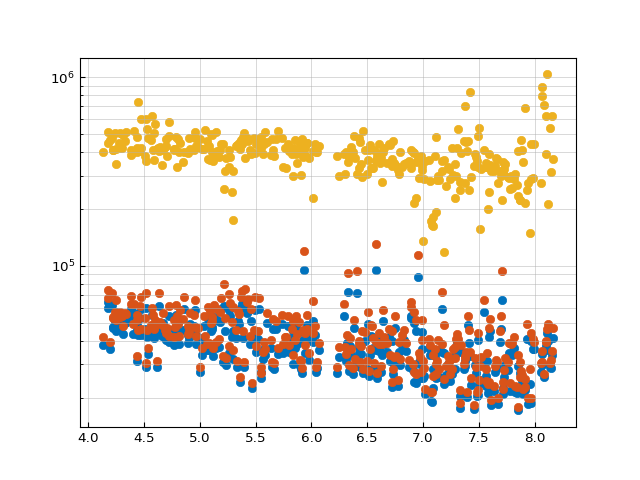

In [7]:
fig, ax = plt.subplots()
ax.scatter(f0, Ql)
ax.scatter(f0, Qc)
ax.scatter(f0, Qi)
ax.set_yscale('log')
np.sum(np.isnan(f0))

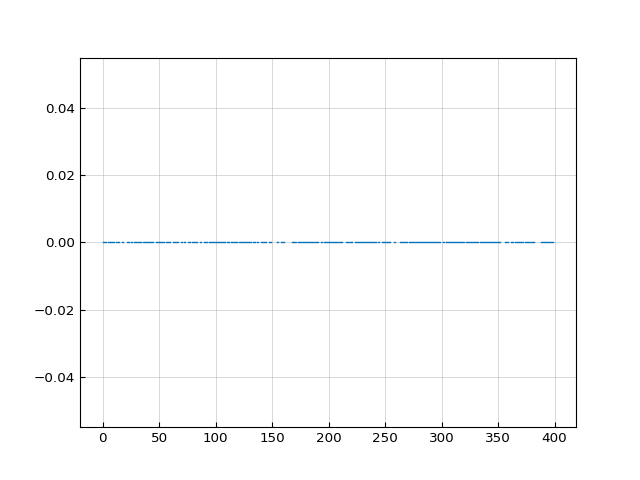

In [8]:
f0 = Qs_sorted[:, 0]
Ql = Qs_sorted[:, 1]
Qc = Qs_sorted[:, 3]
Qi = Qs_sorted[:, 2]
phi = Qs_sorted[:, 4]

df_f0_Q = np.array(df_extended['f0_Q'])
fig, ax = plt.subplots()
ax.plot(df_f0_Q-f0, label='Ql')

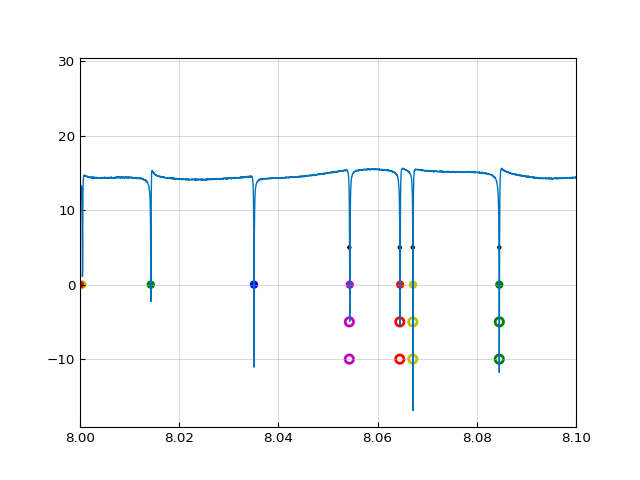

In [9]:
[dark_freqs, dark_s21] = np.load('LT361w2chip4nibbled.npy')
fig, ax = plt.subplots()
ax.plot(dark_freqs, dark_s21)
colors = ['r', 'g', 'b', 'c', 'm', 'y']
f0_Q = Qs[:, 0]
f0_corr = f0
ax.scatter(f0_Q, 5*np.ones(len(f0_Q)), facecolor='k', edgecolor='None', s=10, label='f0 mapped')
for idx, f in enumerate(f0_mapped):
    c= colors[idx%len(colors)]
    ax.scatter(f0_mapped[idx], 0, facecolor=c, edgecolor='none', linewidth=2)
    # ax.text(f0_mapped[idx], 0, str(idx), fontsize=8, color=c, ha='center', va='bottom')
    ax.scatter(df_f0_Q[idx], -5, facecolor='None', edgecolor=c, linewidth=2)
    # ax.text(df_extended['f0_Q'][idx], -5, str(idx), fontsize=8, color=c, ha='center', va='bottom')
    ax.scatter(f0_corr[idx], -10, facecolor='None', edgecolor=c, linewidth=2)
    # ax.text(f0_corr[idx], -10, str(idx), fontsize=8, color=c, ha='center', va='bottom')
    # ax.scatter(f0_Q[idx], 0, facecolor=c, edgecolor='None')
_ = ax.set_xlim((8, 8.1))

c:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\spatial-mapping\.venv\lib\site-packages\numpy\lib\histograms.py:400: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
c:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\spatial-mapping\.venv\lib\site-packages\numpy\lib\histograms.py:401: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
c:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\spatial-mapping\.venv\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\spatial-mapping\.venv\lib\site-packages\numpy\lib\histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(-0.13948279583962092, 0.31601958318137197)

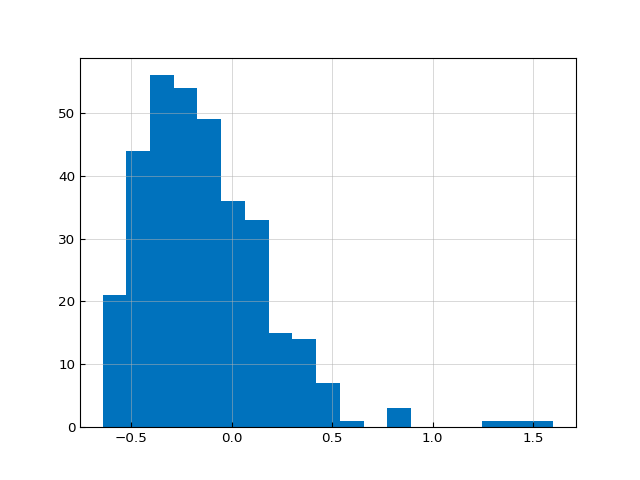

In [11]:
fig, ax = plt.subplots()
Q = np.array(df_extended['Qc'])
# Q = Qs_sorted[:, 3]
Qd = 50e3
dQ_Q = (Q - Qd)/Qd
_ = ax.hist(dQ_Q, bins='auto')
np.nanmean(dQ_Q), np.nanstd(dQ_Q)

In [ ]:
extended_master_array = df_extended.to_numpy()
plt.figure()
plt.plot( extended_master_array[:, 9], 'o', label = 'f0_meas')
plt.plot( extended_master_array[:, 11], 'o', label = 'f0_Q')
plt.grid()
plt.show()



# Zet arrays om voor plotten
f0_meas_array = f0_meas.astype(float)
f0_q_array = np.array(extra_data['f0_Q'], dtype=float)

# 1. Gematchte paren
matched_mask = ~np.isnan(f0_q_array)
matched_f0_meas = f0_meas_array[matched_mask]
matched_f0_q = f0_q_array[matched_mask]

# 2. Niet-gematchte f0_meas
unmatched_f0_meas = f0_meas_array[(~matched_mask) & valid_f0_mask]

# 3. f0_meas uit VenA-clusters
clustered_f0s = f0_meas_array[list(invalid_idx)]

# --- Plot ---
plt.figure(figsize=(10, 6))

# Verbonden lijnen: matched paren
for x, y in zip(matched_f0_meas, matched_f0_q):
    plt.plot([x, y], [0, 1], color='blue', alpha=0.5)

# Punten: matched f0_meas en f0_Q
plt.scatter(matched_f0_meas, np.zeros_like(matched_f0_meas), label='f0_meas (matched)', color='blue', s=20)
plt.scatter(matched_f0_q, np.ones_like(matched_f0_q), label='f0_Q (matched)', color='green', s=20)

# Niet-gematchte f0_meas
plt.scatter(unmatched_f0_meas, np.zeros_like(unmatched_f0_meas), label='f0_meas (unmatched)', color='red', s=20, marker='x')

# Clustered f0_meas
plt.scatter(clustered_f0s, np.full_like(clustered_f0s, -0.2), label='f0_meas (clustered)', color='gray', s=20, marker='o')

# Labels en layout
plt.yticks([0, 1], ['f0_meas', 'f0_Q'])
plt.xlabel('Frequentie (GHz)')
plt.title('Gekoppelde frequenties tussen f0_meas en f0_Q')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# de data shiften

shift = extended_master_array[:, 11] - extended_master_array[:, 9] #f0_Q - f0_meas
mean_shift = np.nanmean(shift)
print(mean_shift) 

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(freqs+mean_shift, dark, label = '.npy', color = 'blue')
ax.vlines(f0s, ymin = -40, ymax = 20, color = 'red', linestyle = '--', label = 'Labview(f0s)')
ax.vlines(f0_meas + mean_shift, ymin = -40, ymax = 20, color='green',linestyle = '--', label = 'Python(f0_meas)')
ax.plot(freqs_sweep, dark_sweep-20, label = 'dark', color = 'black')
#ax.plot(sweep[:, 0], sweep[:, 1], color = 'blue', label = 'VA sweep')
#ax.set_xlim(4.24, 4.28)
ax.set_xlabel('Frequency (GHz)')    
ax.set_ylabel('S21(dB)') #???
ax.set_title('VA sweeps')
ax.legend()



In [ ]:
# nog eens hetzelfde script uitvoeren, maar dan met de shift
freqs_shifted = freqs + mean_shift
f0_meas_shifted = f0_meas + mean_shift
master_array_shifted = master_array.copy()
master_array_shifted[:, 9] = f0_meas_shifted

# -- 1. Bereid master-frequenties voor (f0_meas) --

# Zet f0_meas in float-array als dat nog niet is gedaan
f0_meas = np.array(master_array[:, 9], dtype=float)

# -- 2. Verwijder f0_meas-clusters (te dicht bij elkaar) --
min_distance = 0.0005  # GHz
sort_idx = np.argsort(f0_meas_shifted)
sorted_f0s = f0_meas_shifted[sort_idx]

# Vind te dichte buren
too_close = np.abs(np.diff(sorted_f0s)) < min_distance
invalid_idx = set()

for i, close in enumerate(too_close):
    if close:
        # Voeg beide frequenties toe (voorkant en achterkant)
        invalid_idx.add(sort_idx[i])
        invalid_idx.add(sort_idx[i + 1])

# Masker met True voor geldige f0_meas
valid_f0_mask = np.array([i not in invalid_idx for i in range(len(f0_meas_shifted))])

# -- 3. Initialiseer lege kolommen --
extra_data = {
    'KID': np.full(f0_meas_shifted.shape, '', dtype=object),
    'f0_Q': np.full(f0_meas_shifted.shape, np.nan),
    'Ql': np.full(f0_meas_shifted.shape, np.nan),
    'Qc': np.full(f0_meas_shifted.shape, np.nan),
    'Qi': np.full(f0_meas_shifted.shape, np.nan),
    'dw': np.full(f0_meas_shifted.shape, np.nan),
}
gebruikt = np.full(f0_meas_shifted.shape, False)

# -- 4. Match alleen geldige f0_meas én als f0_Q > f0_meas --
tolerance = 0.01  # GHz

for _, row in df.iterrows():
    f_q = row['f0']
    verschil = np.abs(f0_meas_shifted - f_q)

    # Vind kandidaten: nog niet gebruikt, niet te dicht, binnen tolerantie, én f0 < f_q
    kandidaten = np.where(
        (~gebruikt) &
        valid_f0_mask &
        (verschil <= tolerance) 
    )[0]

    if len(kandidaten) == 0:
        continue

    # Kies dichtstbijzijnde geldige kandidaat
    idx = kandidaten[np.argmin(verschil[kandidaten])]
    
     # Vul extra_data
    extra_data['KID'][idx] = row['KID']
    extra_data['f0_Q'][idx] = f_q
    extra_data['Ql'][idx] = row['Ql']
    extra_data['Qc'][idx] = row['Qc']
    extra_data['Qi'][idx] = row['Qi']
    extra_data['dw'][idx] = row['dw']

    gebruikt[idx] = True

# -- 5. Combineer alles --
extended_master_array = np.column_stack((
    master_array_shifted,
    extra_data['KID'],
    extra_data['f0_Q'],
    extra_data['Ql'],
    extra_data['Qc'],
    extra_data['Qi'],
    extra_data['dw']
))

colnames = ['col0', 'col1', 'col2', 'col3', 'col4', 'col5', 'f0_meas','col7','col8','col9', 'KID', 'f0_Q', 'Ql', 'Qc', 'Qi','dw']
#colnames = ['col0', 'col1', 'col2', 'col3', 'col4', 'col5', 'f0_meas', 'KID', 'f0_Q', 'Ql', 'Qc', 'Qi','dw']
df_extended = pd.DataFrame(extended_master_array, columns=colnames)

# Preview
#print(df_extended.head())
print(df_extended[['KID', 'col9', 'f0_Q', 'Ql', 'Qc', 'Qi','dw']]) #, 'Ql', 'Qc', 'Qi','dw'

# 1. Frequencies die te dicht op elkaar zaten
clustered_f0s = np.sort(f0_meas_shifted[list(invalid_idx)])
print("\n⚠️ f0_meas uitgesloten wegens clustering (VenA-ripples):")
print(clustered_f0s)

# 2. Frequencies die niet gekoppeld zijn (geen match gevonden)
ongekoppeld_idx = np.where((~gebruikt) & valid_f0_mask)[0]
ongekoppelde_f0s = f0_meas_shifted[ongekoppeld_idx]
print("\n❌ f0_meas niet gekoppeld (geen geldige f0_Q match):")
print(ongekoppelde_f0s)

# Optioneel: aantallen
print(f"\nTotaal aantal uitgesloten door clustering: {len(clustered_f0s)}")
print(f"Aantal niet-gematchte, geldige f0_meas: {len(ongekoppelde_f0s)}")

In [ ]:
extended_master_array = df_extended.to_numpy()  # Convert DataFrame to NumPy array with float64 type
f0_meas = extended_master_array[:, 9]
f0_Q = extended_master_array[:,11]


Ql_meas = extended_master_array[:, 12]
Qc_meas = extended_master_array[:, 13]
Qi_meas = extended_master_array[:, 14]


# Create a mask where Qi_meas < 0
mask_Qi = (Qi_meas > 0)  & (Qi_meas < 1e6)
mask_Qc = Qc_meas < 1e5
mask = mask_Qi  & mask_Qc

# Replace values with np.nan where Qi_meas < 0
f0_meas = f0_meas[mask] 
Ql_meas = Ql_meas[mask]
Qc_meas = Qc_meas[mask] 
Qi_meas = Qi_meas[mask] 

def fit(x, a, b):   
    return a*x**(-2)+b 

popt, pcov = curve_fit(fit, f0_meas, Qc_meas)
f0_meas_fit = np.linspace(np.min(f0_meas), np.max(f0_meas),len(Qc_meas))

Q = popt[0]/f0_meas**2 + popt[1]


plt.figure(figsize=(12,4))
plt.yscale('log')
plt.scatter(f0_meas, Qc_meas, label = "Qc's chip 4 trim", alpha = 0.5, color = 'blue')
plt.scatter(f0_meas, Qi_meas, label = "Qi's chip 4 trim", alpha = 0.5, color = 'green')
plt.scatter(f0_meas, Ql_meas, label = "Ql's chip 4 trim", alpha = 0.7, color = 'orange' )
plt.axhline(50000, linestyle = 'dashed', color = 'black', label = '$5 \cdot 10^4$')
plt.plot(f0_meas, fit(f0_meas_fit, *popt), label='fit $y=a/x^2 +b$', c='r', ls='--')
plt.xlabel ('f ($GHz$)')
plt.ylabel ('$Q$')
plt.legend(loc='upper left')
# plt.savefig("Q's chip 4 trim")
plt.show()




In [ ]:
Qc_meas_chip4 = np.loadtxt(r'C:\Users\mpwhe\OneDrive\Documenten\BEP\BEP data\LT361chip4 trimmed\LT361chip4 trimmed\Qc_meas_chip4.csv')
Qc_meas_chip4_master = np.loadtxt(r'C:\Users\mpwhe\OneDrive\Documenten\BEP\BEP data\LT361chip4 trimmed\LT361chip4 trimmed\Qc_meas_chip4_master.csv')
extended_master_array_chip4 = np.load('master array chip4.npy', allow_pickle=True) 

#residu_master = extended_master_array[:, 13] - Qc_meas_chip4_master
residu_master = extended_master_array_chip4[:,13] - extended_master_array[:,13]

# oke dus alleen Qc's van elkaar af trekken als het KID nummer hetzelfde is

sort_index_4 = np.argsort(extended_master_array_chip4[:, 1])[::-1]
sort_index_4nibble = np.argsort(extended_master_array[:, 1])[::-1]
sorted_4 = extended_master_array_chip4[sort_index_4]
sorted_4nibble = extended_master_array[sort_index_4nibble]



# Zet arrays om naar dicts voor snelle lookup
dict_A = {row[10]: row[13] for row in extended_master_array_chip4}
dict_B = {row[10]: row[13] for row in extended_master_array}
# dict_A = {KID_chip4: Qc_meas_chip4}
# dict_B = {KID_chip4: Qc_meas_chip4nibble}
# print(dict_A)
# print(dict_B)

# Vind gedeelde IDs
gemeenschappelijke_ids = set(dict_A.keys()) & set(dict_B.keys())

# Bereken verschillen
# waarden_A = [(id_, dict_A[id_]) for id_ in gemeenschappelijke_ids]
# waarden_B = [(id_, dict_B[id_]) for id_ in gemeenschappelijke_ids]  
# print(waarden_A[1,:])
# print(waarden_B[1,:])         
verschillen = [(id_, dict_A[id_] - dict_B[id_]) for id_ in gemeenschappelijke_ids]

# Eventueel naar array
verschillen_array = np.array(verschillen)

# Zorg ervoor dat alle keys ints zijn
# Alleen geldige numerieke keys behouden
dict_A = {int(k): v for k, v in dict_A.items() if str(k).isdigit()}
dict_B = {int(k): v for k, v in dict_B.items() if str(k).isdigit()}

# Pak gewoon de gemeenschappelijke IDs zonder sorteren
common_ids = set(dict_A.keys()) & set(dict_B.keys())

# Zet per ID de kolommen naast elkaar
values_A_common = np.column_stack([dict_A[id_] for id_ in common_ids])
values_B_common = np.column_stack([dict_B[id_] for id_ in common_ids])
ids_common = np.array(list(common_ids))  # als je ze toch apart wil opslaan


# ids = verschillen_array[:, 0].astype(int) 
waardes = verschillen_array[:, 1].astype(float)

sesidue = values_A_common-values_B_common
#print(sesidue, ids_common)
print('mean is',np.nanmean(sesidue))
print('std is:',np.nanstd(sesidue))
plt.figure()
plt.scatter(ids_common,values_A_common, label= 'Qc chip 4')
plt.scatter(ids_common, values_B_common, label= 'Qc chip 4 nibble')
plt.axhline(50000, linestyle = 'dashed', color = 'black')
plt.legend()
plt.show()

plt.figure()
plt.scatter(ids_common, sesidue, label = 'Qc residue')
plt.axhline(np.nanmean(sesidue), linestyle = 'dashed', color = 'black')
plt.legend()
plt.show()

In [ ]:
KID_chip4 = extended_master_array_chip4[:,10]
KID_chip4nibble = extended_master_array[:,10]
Qc_meas_chip4 = extended_master_array_chip4[:,13]
Qc_meas_chip4nibble = extended_master_array[:,13]
Qi_meas_chip4 = extended_master_array_chip4[:,14]
Qi_meas_chip4nibble = extended_master_array[:,14]

# Create a mask where Qi_meas < 0
mask_Qi_chip4 = (Qi_meas_chip4 > 0) & (Qi_meas_chip4 < 2e6)   #misschien werkt dit niet
mask_Qi_chip4nibble = (Qi_meas_chip4nibble > 0)  & (Qi_meas_chip4nibble < 2e6)
mask_Qc_chip4 = Qc_meas_chip4 < 1.5e5
mask_Qc_chip4nibble = Qc_meas_chip4nibble < 1.5e5
mask_residue = mask_Qi_chip4  & mask_Qc_chip4 & mask_Qi_chip4  & mask_Qc_chip4

# Replace values with np.nan where Qi_meas < 0
KID_chip4 = KID_chip4[mask_residue]
KID_chip4nibble = KID_chip4nibble[mask_residue]
Qc_meas_chip4 = Qc_meas_chip4[mask_residue] 
Qc_meas_chip4nibble = Qc_meas_chip4nibble[mask_residue] 
Qi_meas_chip4 = Qi_meas_chip4[mask_residue] 
Qi_meas_chip4nibble = Qi_meas_chip4nibble[mask_residue] 

verschillen_Qc = []
verschillen_Qi = []
ids_voor_verschil = []

for i in range(len(KID_chip4)):
    for j in range(len(KID_chip4nibble)):
        if KID_chip4[i] == KID_chip4nibble[j]:
            verschil_Qc = Qc_meas_chip4[i] - Qc_meas_chip4nibble[j]
            verschillen_Qc.append(verschil_Qc)
            verschil_Qi = Qi_meas_chip4[i] - Qi_meas_chip4nibble[j]
            verschillen_Qi.append(verschil_Qi)
            ids_voor_verschil.append(KID_chip4[i])
verschillen_Qc = np.array([verschillen_Qc])
# verschillen_Qc = verschillen_Qc[verschillen_Qc > -2e5 ]

print(np.mean(verschillen_Qc))
print(np.std(verschillen_Qc))
plt.figure()
plt.scatter(ids_voor_verschil, verschillen_Qc)
plt.show()

In [ ]:

Qi_meas_chip4_master = np.loadtxt(r'C:\Users\mpwhe\OneDrive\Documenten\BEP\BEP data\LT361chip4 trimmed\LT361chip4 trimmed\Qi_meas_chip4_master.csv')
mask_chip4 = Qc_meas_chip4_master < 1.5e5
mask_chip4_Qi = (Qi_meas_chip4_master > 0)  & (Qi_meas_chip4_master < 2e6)
Qc_meas_chip4_master = Qc_meas_chip4_master[mask]
Qi_meas_chip4_master = Qi_meas_chip4_master[mask]
residue = Qc_meas_chip4_master - Qc_meas
residue_Qi = Qi_meas_chip4_master - Qi_meas
#residue = Qc_meas -Qc_meas_chip4_master 

kid_id_board = np.ones((20, 20), dtype=int)
kid_id_board[master_array[:,1].astype(int), master_array[:,2].astype(int)] = master_array[:,0]

plt.figure()
plt.scatter(f0_meas, Qc_meas, label = "Qc's chip 4 nibble")
plt.axhline(50000, linestyle = 'dashed', color = 'black')
plt.xlabel ('f ($GHz$)')
plt.ylabel ('$Q_c$')
plt.legend()
plt.savefig("Qc's chip 4 nibble")
plt.show()

plt.figure()
plt.scatter(f0_meas, Qc_meas, label = "Qc's chip 4 nibble")
plt.scatter(f0_meas, Qc_meas_chip4_master, label = "Qc's chip 4")
plt.axhline(50000, linestyle = 'dashed', color = 'black')
plt.xlabel ('f ($GHz$)')
plt.ylabel ('$Q_c$')
plt.legend()
plt.savefig("Qc's chip 4 nibble")
plt.show()

plt.figure()
plt.scatter(extended_master_array[:,9], residu_master, label = "residue master chip 4")
#plt.axhline(50000, linestyle = 'dashed', color = 'black')
plt.xlabel ('f ($GHz$)')
plt.ylabel ('$dQ_c$')
plt.ylim(-150000,150000)
plt.legend()
plt.savefig("residue chip 4")
plt.show()

plt.figure()
plt.scatter(f0_meas, residue, label = "residue chip 4")
#plt.axhline(50000, linestyle = 'dashed', color = 'black')
plt.xlabel ('f ($GHz$)')
plt.ylabel ('$dQ_c$')
plt.ylim(-150000,150000)
plt.legend()
plt.savefig("residue chip 4")
plt.show()

mask_residue = (residue < 1.5e5) & (residue > -1.5e5)
residue = residue[mask_residue]

print(np.nanmean(residue))
print(np.nanstd(residue))
print(np.nanmean(residu_master))
print(np.nanstd(residu_master))

plt.figure()
plt.hist(residue, bins=50, label='residue Q_c')
#plt.plot(x_frac, p_frac, 'r-', linewidth=2, label='Fitted Normal')
plt.xlabel('Residue') 
plt.ylabel('Count')
# plt.xlim(-2,4)
plt.legend()
plt.savefig('histogram of residue_Qc')
plt.show()


plt.figure()
plt.scatter(f0_meas, residue_Qi, label = "residue of Q_i chip 4")
#plt.axhline(50000, linestyle = 'dashed', color = 'black')
plt.xlabel ('f ($GHz$)')
plt.ylabel ('$dQ_i$')
# plt.ylim(-150000,150000)
plt.legend()
plt.savefig("residue Qi chip 4")
plt.show()

mask_residue_Qi = (residue_Qi < 5e6) & (residue_Qi > -5e6)
residue_Qi = residue_Qi[mask_residue_Qi]

print(np.nanmean(residue_Qi))
print(np.nanstd(residue_Qi))

plt.figure()
plt.hist(residue_Qi, bins=50, label='residue Q_i')
#plt.plot(x_frac, p_frac, 'r-', linewidth=2, label='Fitted Normal')
plt.xlabel('residue') 
plt.ylabel('count')
# plt.xlim(-2,4)
plt.legend()
plt.savefig('histogram of residue_Qi')
plt.show()

print(len(residue), len(residue_Qi))
plt.figure()
plt.scatter(residue, residue_Qi)
plt.show()



In [ ]:
f0_meas = extended_master_array[:, 9]
Ql_meas = extended_master_array[:, 12]
Qc_meas = extended_master_array[:, 13]
Qi_meas = extended_master_array[:, 14]

Qc_meas_chip4_master = np.loadtxt(r'C:\Users\mpwhe\OneDrive\Documenten\BEP\BEP data\LT361chip4 trimmed\LT361chip4 trimmed\Qc_meas_chip4_master.csv')
print(Qc_meas_chip4_master.shape)
residu_master = extended_master_array[:, 13] - Qc_meas_chip4_master
Qi_meas_chip4_master = np.loadtxt(r'C:\Users\mpwhe\OneDrive\Documenten\BEP\BEP data\LT361chip4 trimmed\LT361chip4 trimmed\Qi_meas_chip4_master.csv')
print(Qc_meas_chip4_master)
print(Qc_meas)
residue = Qc_meas_chip4_master - Qc_meas
residue_Qi = Qi_meas_chip4_master - Qi_meas

print(np.nanmean(residue))
print(np.nanstd(residue))
print(np.nanmean(residu_master))
print(np.nanstd(residu_master))

plt.figure()
plt.scatter(f0_meas, residue, label = "residue $Q_c$ chip 4")
#plt.axhline(50000, linestyle = 'dashed', color = 'black')
plt.xlabel ('f ($GHz$)')
plt.ylabel ('$dQ_c$')
#plt.ylim(-150000,150000)
plt.legend()
plt.savefig("residue chip 4")
plt.show()

plt.figure()
plt.hist(residue, bins=50, label='residue Q_c')
#plt.plot(x_frac, p_frac, 'r-', linewidth=2, label='Fitted Normal')
plt.xlabel('Residue') 
plt.ylabel('Count')
# plt.xlim(-2,4)
plt.legend()
plt.savefig('histogram of residue_Qc')
plt.show()


plt.figure()
plt.scatter(f0_meas, residue_Qi, label = "residue of Q_i chip 4")
#plt.axhline(50000, linestyle = 'dashed', color = 'black')
plt.xlabel ('f ($GHz$)')
plt.ylabel ('$dQ_i$')
# plt.ylim(-150000,150000)
plt.legend()
plt.savefig("residue Qi chip 4")
plt.show()

mask_residue_Qi = (residue_Qi < 5e6) & (residue_Qi > -5e6)
residue_Qi = residue_Qi[mask_residue_Qi]

print(np.nanmean(residue_Qi))
print(np.nanstd(residue_Qi))

plt.figure()
plt.hist(residue_Qi, bins=50, label='residue Q_i')
#plt.plot(x_frac, p_frac, 'r-', linewidth=2, label='Fitted Normal')
plt.xlabel('residue') 
plt.ylabel('count')
# plt.xlim(-2,4)
plt.legend()
plt.savefig('histogram of residue_Qi')
plt.show()



In [ ]:
def fit(x, a, b):   
    return a*x**(-2)+b 

f0s = np.array(df['f0'])
Qs = np.array(df['Ql'])
Qis = np.array(df['Qi'])
Qcs = np.array(df['Qc'])


# # mask only for this cell to get rid of Nan values
# f0_meas = f0_meas.astype(float)
# Ql_meas = Ql_meas.astype(float)
# Qc_meas = Qc_meas.astype(float)
# Qi_meas = Qi_meas.astype(float)
# # Create a mask where all values are not NaN
# mask_valid = ~np.isnan(f0_meas) & ~np.isnan(Ql_meas) & ~np.isnan(Qc_meas) & ~np.isnan(Qi_meas)
# # Apply the mask to each array
# f0_meas = f0_meas[mask_valid]
# Ql_meas = Ql_meas[mask_valid]
# Qc_meas = Qc_meas[mask_valid]
# Qi_meas = Qi_meas[mask_valid]


min_df = 0.002
df0s = f0s[1:] - f0s[:-1]
df_mask = np.zeros(f0s.shape, dtype=bool)
too_close = df0s < min_df
too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))
print(np.sum(too_close_mask))
popt, pcov = curve_fit(fit, f0s[~too_close_mask], Qcs[~too_close_mask])
f0s_fit = np.linspace(f0s[~too_close_mask].min(), f0s[~too_close_mask].max(), 100)

fig, ax = plt.subplots(figsize=(4,4))
ax.set_title('LT361chip4')
ax.set_yscale('log')
ax.scatter(f0s[~too_close_mask], Qs[~too_close_mask], label='Q')
ax.scatter(f0s[~too_close_mask], Qis[~too_close_mask], label='Qis')
ax.scatter(f0s[~too_close_mask], Qcs[~too_close_mask], label='Qcs')
ax.plot(f0s_fit, fit(f0s_fit, *popt), label='fit $y=a/x^2 +b$', c='k', ls='--')
ax.set_xlim(4,8)
ax.set_xlabel('Frequency (GHz)')    
ax.set_ylim(1e3, 1e6)
ax.set_ylabel('Q')
ax.legend()
print(*popt)

min_df = 0.002
df0_meas = f0_meas[1:] - f0_meas[:-1]
df__meas_mask = np.zeros(f0_meas.shape, dtype=bool)
too_close = df0_meas < min_df
too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))
print(np.sum(too_close_mask))
popt, pcov = curve_fit(fit, f0_meas[~too_close_mask], Qc_meas[~too_close_mask])
f0_meas_fit = np.linspace(f0_meas[~too_close_mask].min(), f0_meas[~too_close_mask].max(), 100)

fig, ax = plt.subplots(figsize=(4,4))
ax.set_title('LT361chip4')
ax.set_yscale('log')
ax.scatter(f0_meas[~too_close_mask], Ql_meas[~too_close_mask], label='Ql_meas')
ax.scatter(f0_meas[~too_close_mask], Qi_meas[~too_close_mask], label='Qi_meas')
ax.scatter(f0_meas[~too_close_mask], Qc_meas[~too_close_mask], label='Qc_meas')
ax.plot(f0_meas_fit, fit(f0_meas_fit, *popt), label='fit $y=a/x^2 +b$', c='k', ls='--')
ax.set_xlim(4,8)
ax.set_xlabel('Frequency (GHz)')    
ax.set_ylim(1e3, 1e6)
ax.set_ylabel('Q')
ax.grid()
ax.legend()
print(*popt)




In [ ]:

# f0_meas = extended_master_array[:, 6]
# Ql_meas = extended_master_array[:, 12]
# Qc_meas = extended_master_array[:, 13]
# Qi_meas = extended_master_array[:, 14]


# # Create a mask where Qi_meas < 0
# mask_Qi = (Qi_meas > 0)  & (Qi_meas < 1e6)
# mask_Qc = Qc_meas < 1e5
# mask = mask_Qi  & mask_Qc

# # Replace values with np.nan where Qi_meas < 0
# f0_meas = f0_meas[mask] 
# Ql_meas = Ql_meas[mask]
# Qc_meas = Qc_meas[mask] 
# Qi_meas = Qi_meas[mask] 

Q = popt[0]/f0_meas**2 + popt[1]  #f0_meas or f0_meas_shifted?

Ql_spatiel = Ql_meas - Q
Qc_spatiel = Qc_meas - Q

plt.figure()
plt.scatter(f0_meas, Qc_spatiel, label = "Qc's chip 4 nibble without f-relation")
plt.axhline(50000, linestyle = 'dashed', color = 'black')
plt.xlabel ('f ($GHz$)')
plt.ylabel ('$Q_c$')
plt.legend()
plt.savefig("Qc's chip 4 nibble without f-relation")
plt.show()

Q_designed = Q
frac_Ql = (Ql_meas-Q_designed)/Q_designed
mean_frac_Ql = np.nanmean(frac_Ql)
std_frac_Ql = np.nanstd(frac_Ql)

frac_Qc = (Qc_meas-Q_designed)/Q_designed
mean_frac_Qc = np.nanmean(frac_Qc)
std_frac_Qc = np.nanstd(frac_Qc)




# Qc_meas_hist = Qc_meas[Qc_meas < 220000]  # filter outliers


print(f"Mean fractional Qc: {mean_frac_Qc}, Std fractional Qc: {np.nanstd(frac_Qc)}")
print(f"Mean fractional Ql: {mean_frac_Ql}, Std fractional Ql: {std_frac_Ql}")

mean_Qc_meas = np.nanmean(Qc_meas)
print(f"Mean Qc_meas: {mean_Qc_meas}")
std_Qc_meas = np.nanstd(Qc_meas)
print(f"Std Qc_meas: {std_Qc_meas}")

plt.figure()
plt.hist(Qc_meas/1e4, bins=20, density=True, label='Qc_meas')
plt.xlabel('Qc_meas x 1e4')
plt.ylabel('Density')
plt.axvline(np.nanmean(Qc_meas)/1e4, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.nanmean(Qc_meas):.2f}')
plt.legend()
plt.show()



In [ ]:
frac_Qc = np.array(frac_Qc, dtype=float) 
frac_Qc = frac_Qc[np.isfinite(frac_Qc)]  # filter out NaN values
frac_Ql = np.array(frac_Ql, dtype=float) 
frac_Ql = frac_Ql[np.isfinite(frac_Ql)]  # filter out NaN values
Qc_meas = np.array(Qc_meas, dtype=float)
Qc_meas = Qc_meas[np.isfinite(Qc_meas)]  # filter out NaN values
#Qc_meas = Qc_meas[Qc_meas < 250000]  # filter outliers

mu_Qc, std_Qc = norm.fit(Qc_meas)
mu_frac_Qc, std_frac_Qc = norm.fit(frac_Qc)
mu_frac_Ql, std_frac_Ql = norm.fit(frac_Ql)
print(f"Fitted mu_Qc: {mu_Qc}, std_Qc: {std_Qc}")
print(f"Fitted mu_frac_Qc: {mu_frac_Qc}, std_frac_Qc: {std_frac_Qc}")
print(f"Fitted mu_Ql: {mu_frac_Ql}, std_Ql: {std_frac_Ql}")



# Plot the PDF of the fitted normal distribution

#x = np.linspace(0,20, 100)
x = np.linspace(min(Qc_meas/1e4), max(Qc_meas/2e4), 100)
x_frac = np.linspace (min(frac_Qc), max(frac_Qc), 100)  # for fractional Ql and Qc
x_frac_Ql = np.linspace(min(frac_Ql), max(frac_Ql), 100)  # for fractional Ql
# = norm.pdf(x, mu_Qc, std_Qc)
p = norm.pdf(x, mu_Qc/1e4, std_Qc/1e4)
p_frac = norm.pdf(x_frac, mu_frac_Qc, std_frac_Qc)
p_frac_Ql = norm.pdf(x_frac_Ql, mu_frac_Ql, std_frac_Ql)

plt.figure()
plt.hist(frac_Qc, bins=50, label='Fractional Qc chip 4 trimmed', color = 'purple')
#plt.plot(x_frac, p_frac, 'r-', linewidth=2, label='Fitted Normal')
plt.xlabel('fractional Qc') 
plt.ylabel('Number of KIDs')
plt.xlim(-2,4)
plt.legend()
plt.savefig('histogram frac Qc chip 4 nibble')
plt.show()

plt.figure()
plt.hist(frac_Ql, bins=50, density=True, label='Fractional Ql')
plt.plot(x_frac_Ql, p_frac_Ql, 'r-', linewidth=2, label='Fitted Normal')
plt.xlabel('fractional Ql')
plt.ylabel('Density')
plt.legend()
plt.show()


In [54]:

# # Qi_meas = extended_master_array[:, 14]
# # Qc_meas = extended_master_array[:, 13]


# Qc_meas = Qc_meas.astype(float)
# Qi_meas = Qi_meas.astype(float)
# # Qc_meas[Qc_meas > 150000] = np.nan
# # Qi_meas[Qi_meas > 2000000]=np.nan
# # Qi_meas[Qi_meas < 0]=np.nan

# mask = ~np.isnan(Qc_meas) & ~np.isnan(Qi_meas)
# Qc_meas, Qi_meas = Qc_meas[mask], Qi_meas[mask]
# print(np.max(Qc_meas))




# correlation_matrix = np.corrcoef(Qc_meas, Qi_meas)
# correlation_Q = np.correlate(Qc_meas, Qi_meas)
# print(correlation_Q)

# # Extract the correlation coefficient
# correlation = correlation_matrix[0, 1]
# print(correlation)

# plt.figure()
# plt.scatter(Qc_meas, Qi_meas)
# plt.xlabel('Qc')
# plt.ylabel('Qi')
# # plt.xlim(0,80000)
# # plt.ylim(0,800000)
# plt.show()



In [ ]:
# Create the multi-panel figure
f0_meas = extended_master_array[:, 6]
Ql_meas = extended_master_array[:, 12]
Qc_meas = extended_master_array[:, 13]
Qi_meas = extended_master_array[:, 14]


# Create a mask where Qi_meas < 0
mask_Qi = (Qi_meas > 0)  & (Qi_meas < 2e6)
mask_Qc = Qc_meas < 1.5e5
mask = mask_Qi  & mask_Qc

# Replace values with np.nan where Qi_meas < 0
f0_meas = f0_meas[mask] 
Ql_meas = Ql_meas[mask]
Qc_meas = Qc_meas[mask] 
Qi_meas = Qi_meas[mask]


Ql_spatiel = Ql_meas - Q
Qc_spatiel = Qc_meas - Q

Q_designed = Q
frac_Ql = (Ql_meas-Q_designed)/Q_designed
frac_Qc = (Qc_meas-Q_designed)/Q_designed



def reconstruct_array_with_nan(mask, filtered_array):
    full_array = np.full(mask.shape, np.nan)  # Maak array gevuld met nan
    full_array[mask] = filtered_array
    return full_array

# Aanname: valid_mask is van lengte 400
Qc_meas = reconstruct_array_with_nan(mask, Qc_meas)
Ql_meas = reconstruct_array_with_nan(mask, Ql_meas)
Qi_meas = reconstruct_array_with_nan(mask, Qi_meas)
frac_Qc = reconstruct_array_with_nan(mask, frac_Qc)
frac_Ql = reconstruct_array_with_nan(mask, frac_Ql)
Ql_spatiel = reconstruct_array_with_nan(mask, Ql_spatiel)
Qc_spatiel = reconstruct_array_with_nan(mask, Qc_spatiel)


fig, axes = plt.subplots(1, 8, figsize=(40, 15), constrained_layout=True)

im0 = axes[0].imshow(extended_master_array[:,6].astype(float)[kid_id_board], cmap='viridis', origin='lower')
axes[0].set_title('f0_meas')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(Ql_meas.astype(float)[kid_id_board], cmap='viridis', origin='lower', vmin=-10000, vmax=80000)
axes[1].set_title('Ql_meas at certain power')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(Qi_meas.astype(float)[kid_id_board], cmap='viridis', origin='lower', vmin=-500000, vmax=1000000)
axes[2].set_title('Qi_meas at certain power')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

im3 = axes[3].imshow(Qc_meas.astype(float)[kid_id_board], cmap='viridis', origin='lower', vmin=0, vmax=100000)
axes[3].set_title('Qc_meas at certain power')
fig.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

im4 = axes[4].imshow(frac_Ql.astype(float)[kid_id_board], cmap='viridis', origin='lower', vmin=-2, vmax=1)
axes[4].set_title('Fractional Ql at certain power')
fig.colorbar(im4, ax=axes[4], fraction=0.046, pad=0.04)

im5 = axes[5].imshow(frac_Qc.astype(float)[kid_id_board], cmap='viridis', origin='lower', vmin=-2, vmax=1)
axes[5].set_title('Fractional Qc at certain power')
fig.colorbar(im5, ax=axes[5], fraction=0.046, pad=0.04)

im6 = axes[6].imshow(Ql_spatiel.astype(float)[kid_id_board], cmap='viridis', origin='lower', vmin=-50000, vmax=50000)
axes[6].set_title('Ql_spatiel at certain power')
fig.colorbar(im6, ax=axes[6], orientation='vertical', fraction=0.05, pad=0.04)

im7 = axes[7].imshow(Qc_spatiel.astype(float)[kid_id_board], cmap='viridis', origin='lower', vmin=-50000, vmax=30000)
axes[7].set_title('Qc_spatiel at certain power')
fig.colorbar(im7, ax=axes[7], orientation='vertical', fraction=0.05, pad=0.04)



#plt.tight_layout()

# Save the figure to a buffer
buf = io.BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
encoded = base64.b64encode(buf.read()).decode('utf-8')

# Create a scrollable HTML container for the image
html = f'''
<div style="overflow-x: auto; white-space: nowrap; width:3000px; height:1500px border:1px solid #ccc; padding:10px;">
    <img src="data:image/png;base64,{encoded}" style="display: inline-block;" />
</div>
'''

display(HTML(html))
plt.close(fig)  


In [56]:
# Nieuwe figuur en as aanmaken
fig_single, ax_single = plt.subplots(figsize=(5, 5))  # pas grootte aan indien nodig

# Hetzelfde plot opnieuw tekenen
im = ax_single.imshow(frac_Qc.astype(float)[kid_id_board], cmap='viridis', origin='lower', vmin=-1, vmax=1)
#ax_single.set_title('Fractional Qc at certain power')

# Colorbar toevoegen
fig_single.colorbar(im, ax=ax_single, fraction=0.046, pad=0.04)

# Opslaan
fig_single.savefig('Heatmap_frac_Qc_chip4nibble_only.png', bbox_inches='tight', dpi=300)
plt.close(fig_single)

In [ ]:
dw = pd.to_numeric(extended_master_array[:, 15], errors='coerce')
f0_meas = pd.to_numeric(extended_master_array[:, 6], errors='coerce')
Ql_meas = pd.to_numeric(extended_master_array[:, 12], errors='coerce')

f0_meas = f0_meas[mask] 
Ql_meas = Ql_meas[mask]
dw = dw[mask]

def reconstruct_array_with_nan(mask, filtered_array):
    full_array = np.full(mask.shape, np.nan)  # Maak array gevuld met nan
    full_array[mask] = filtered_array
    return full_array

# Aanname: valid_mask is van lengte 400
f0_meas = reconstruct_array_with_nan(mask, f0_meas)
Ql_meas = reconstruct_array_with_nan(mask, Ql_meas)
dw = reconstruct_array_with_nan(mask, dw)



mask_phi = np.isnan(f0_meas) & np.isnan(Ql_meas) & np.isnan(dw)
phi_400 = np.full_like(f0_meas, np.nan)
w_0 = 2 * np.pi * f0_meas[~mask_phi]  
phi = np.arctan(2*Ql_meas[~mask_phi] *(dw[~mask_phi] / w_0))

# print(phi)
# print(np.shape(phi))

phi_400[~mask_phi] = phi
# print(np.shape(phi_400))
# print(phi_400)


fig,ax = plt.subplots()
im = ax.imshow(phi_400[kid_id_board], cmap='viridis', origin='lower', vmin=-1e-1, vmax=1e-1)
ax.set_title('phi at certain power')
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label("Color scale")


fig,ax = plt.subplots()
plt.plot(f0_meas[~mask_phi],phi, 'o', markersize=2)
plt.xlabel('f0_meas (GHz)') 
plt.ylabel('phi')
plt.title('f0_meas vs phi')

correlation_matrix = np.corrcoef(phi, frac_Qc[~mask_phi])
# Extract the correlation coefficient
correlation = correlation_matrix[0, 1]
print(correlation)
x = np.linspace(-1,3,len(phi))
fig,ax = plt.subplots()
plt.plot(frac_Qc[~mask_phi],phi, 'o', markersize=3, label = 'chip 4 nibble', color = 'purple')
plt.plot(x,x*correlation)
plt.xlabel('fractional $Q_c$') 
plt.ylabel('$\phi$')
#plt.title('fractional $Q_c$ vs phi')
plt.xlim(-1,1)
plt.ylim(-0.3,0.3)
plt.legend()
plt.savefig('frac Qc vs phi chip 4 nibble')

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(25, 5), constrained_layout=True)

im0 = axes[0].plot(f0_meas, Qc_meas, 'o', markersize=2, label='Qc_meas')
axes[0].set_xlabel('f0_meas (GHz)')
axes[0].set_ylabel('Qc_meas')
#axes[0].set_ylim(-50000, 100000)
axes[0].set_title('f0_meas vs Qc_meas')

im1 = axes[1].plot(f0_meas, Qc_spatiel, 'o', markersize=2, label='Qc_spatiel')
axes[1].set_xlabel('f0_meas (GHz)')
axes[1].set_ylabel('Qc_spatiel')
axes[1].set_ylim(-100000, 100000)
axes[1].set_title('f0_meas vs Qc_spatiel')


im2 = axes[2].plot(f0_meas, frac_Qc, 'o', markersize=2, label='Qc_fractional')
axes[2].set_xlabel('f0_meas (GHz)')
axes[2].set_ylabel('Qc_fractional')
axes[2].set_ylim(-5, 10)
axes[2].set_title('f0_meas vs Qc_fractional')

Q_scatter = Qc_meas - 50000
mask_Q = np.isnan(f0_meas)
im3 =axes[3].plot(f0_meas, Q_scatter, 'o', markersize=2, label='Qc_meas - 50000')
axes[3].set_xlabel('f0_meas (GHz)')
axes[3].set_ylabel('Qc_meas - 50000')
# axes[3].set_ylim(-100000, 100000)
axes[3].set_title('f0_meas vs Qc_meas - 50000')


im4 =axes[4].plot(Qc_meas[~mask_Q], phi, 'o', markersize=2, label='Qc_meas')
axes[4].set_ylabel('phi')
axes[4].set_xlabel('Qc_meas')
axes[4].set_ylim(-0.6, 0.6)
axes[4].set_xlim(0, 70000)
axes[4].set_title('Qc_meas vs phi')

im5 =axes[5].plot(Q_scatter[~mask_Q], phi, 'o', markersize=2, label='Qc_meas - 50000')
axes[5].set_ylabel('phi')
axes[5].set_xlabel('Qc_meas - 50000')
axes[5].set_ylim(-0.6, 0.6)
axes[5].set_xlim(-60000, 25000 )
axes[5].set_title('Qc_meas - 50000 vs phi')

# im3 = axes[3].plot(f0_meas, Ql_meas, 'o', markersize=2, label='Ql_meas')
# axes[3].set_xlabel('f0_meas (GHz)')
# axes[3].set_ylabel('Ql_meas')
# axes[3].set_ylim(-50000, 100000)
# axes[3].set_title('f0_meas vs Ql_meas')




# Save the figure to a buffer
buf = io.BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
encoded = base64.b64encode(buf.read()).decode('utf-8')

# Create a scrollable HTML container for the image
html = f'''
<div style="overflow-x: auto; white-space: nowrap; width:2000px; height:800px border:1px solid #ccc; padding:10px;">
    <img src="data:image/png;base64,{encoded}" style="display: inline-block;" />
</div>
'''

display(HTML(html))
plt.close(fig)  


In [59]:
# # correlations with phi
# Qc_meas = Qc_meas.astype(float)
# phi = phi.astype(float)
# print(phi.shape, Qc_meas.shape)
# mask = ~np.isnan(Qc_meas) & ~np.isnan(phi)
# Qc_meas, Qi_meas = Qc_meas[mask], phi[mask]


# correlation_matrix = np.corrcoef(phi, Qc_meas)
# correlation_Q = np.correlate(phi, Qc_meas)
# print(correlation_Q)

# # Extract the correlation coefficient
# correlation = correlation_matrix[0, 1]
# print(correlation)

In [ ]:
fig, ax = plt.subplots(figsize=(12,3), constrained_layout=True)
M =20
N = 20
pp = 150
d = np.arange(0,M*pp, pp)
dmap = np.zeros((M,N))
times = 0 
for i, row in enumerate(dmap):
    if i ==0:
        row += d
    if i !=0:
        if i % 2 == 0:
            row += dmap[i-1,0]+ d
        else:
            row += dmap[i-1,-1] + d[::-1]
dmap
ax.scatter(dmap.flatten()*1e-3, frac_Qc[kid_id_board].flatten(), label = 'chip 4 nibble', color = 'purple', alpha = 0.7)
ax.set_xlabel('distance along the through line [$mm$]')
ax.set_ylabel('fractional $Q_c$')
ax.set_ylim(-1,1)
ax.legend()
fig.savefig('flattenKIDid_chip4nibble', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots(figsize=(12,3), constrained_layout=True)
M =20
N = 20
pp = 150
d = np.arange(0,M*pp, pp)
dmap = np.zeros((M,N))
times = 0 
for i, row in enumerate(dmap):
    if i ==0:
        row += d
    if i !=0:
        if i % 2 == 0:
            row += dmap[i-1,0]+ d
        else:
            row += dmap[i-1,-1] + d[::-1]
dmap
ax.scatter(dmap.flatten()*1e-3, phi_400[kid_id_board].flatten(), label = 'chip 4 nibble', color = 'purple', alpha = 0.7)
ax.set_xlabel('distance along the through line [$mm$]')
ax.set_ylabel('$\phi$')
ax.set_ylim(-0.2,0.2)
ax.legend()
fig.savefig('flattenKIDid_chip4nibble_phi', bbox_inches='tight', dpi=300)